### ToDo

* ...

In [7]:
%%javascript
// keyboard shortcut for running all cells: Ctrl-m + r
Jupyter.keyboard_manager.command_shortcuts.add_shortcut('r', {
    help : 'run all cells',
    help_index : 'zz',
    handler : function (event) {
        IPython.notebook.execute_all_cells();
        return false;
    }}
);

<IPython.core.display.Javascript object>

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from camera_calibration import calibrate_camera, undistort_image
from image_binarization import binarize_frame
from perspective_transformation import get_perspective_transform, warp_image_to_top_down_view
from lane_lines import Line, detect_lane_lines, track_lane_lines, project_lane_lines_to_road, write_curvature_text_to_image, write_lane_offset_text_to_image

def initialize():
    # Calibrate camera
    mtx, dist = calibrate_camera(use_calib_cache=True)
    
    # Perspective transform
    test_image = cv2.cvtColor(cv2.imread('./test_images/straight_lines1.jpg'), cv2.COLOR_BGR2RGB)

    img_undistorted = undistort_image(test_image, mtx, dist, plot_images=False)
    
    img_size = (test_image.shape[1], test_image.shape[0])
    perspective_M, perspective_M_inv = get_perspective_transform(img_size)
    
    return mtx, dist, perspective_M, perspective_M_inv

In [9]:
def test_binarize_frame():
    mtx, dist, perspective_M, perspective_M_inv = initialize()

    # Read in an image
    image = cv2.cvtColor(cv2.imread('./test_images/straight_lines2.jpg'), cv2.COLOR_BGR2RGB)
    img_undistorted = undistort_image(image, mtx, dist, plot_images=False)
    img_binary = binarize_frame(img_undistorted)
    
    img_size = (image.shape[1], image.shape[0])
    top_down_binary = warp_image_to_top_down_view(img_binary.astype(np.uint8), 
                                   img_size, perspective_M).astype(bool)

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(top_down_binary, cmap='gray')
    ax2.set_title('Undistorted and Warped Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    

# test_binarize_frame()


Using already available cached calibration results.

top_down_binary.shape = (720, 1280)
left_fit: [  5.93193079e-06   2.29126109e-02   2.94748692e+02]
right_fit: [ -4.70246069e-06  -2.74283879e-02   9.98546569e+02]


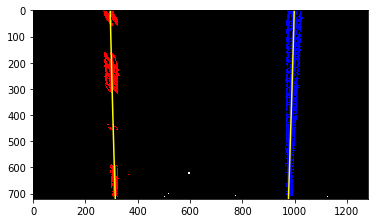

In [4]:
from lane_lines import Line

def test_detect_lane_lines():
    mtx, dist, perspective_M, perspective_M_inv = initialize()    
    line_left = Line()
    line_right = Line()

    # Read in an image
    image = cv2.cvtColor(cv2.imread('./test_images/straight_lines2.jpg'), cv2.COLOR_BGR2RGB)
    img_undistorted = undistort_image(image, mtx, dist, plot_images=False)
    img_binary = binarize_frame(img_undistorted)
    
    img_size = (image.shape[1], image.shape[0])
    top_down_binary = warp_image_to_top_down_view(img_binary.astype(np.uint8), 
                                   img_size, perspective_M).astype(bool)
    
    print("top_down_binary.shape = {}".format(top_down_binary.shape))
    out_image = detect_lane_lines(top_down_binary, line_left, line_right, plot_image=True)

    print("left_fit: {}".format(line_left.line_polyfit))
    print("right_fit: {}".format(line_right.line_polyfit))
    
# test_detect_lane_lines()

In [11]:
# Reset global
num_frames_processed = 0

In [12]:
### Video
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_video_frame(frame):
    # NOTE: output should be a color image (3 channel) for processing video below    
    global dict_config_params
    global num_frames_processed    
    global mtx, dist, perspective_M, perspective_M_inv
    global left_fit, right_fit, left_fitx, right_fitx
    #global line_left, line_right
    
    frame_undistorted = undistort_image(frame, mtx, dist, plot_images=False)
    frame_binary = binarize_frame(frame_undistorted)
    
    frame_size = (frame_binary.shape[1], frame_binary.shape[0])
    top_down_binary = warp_image_to_top_down_view(frame_binary.astype(np.uint8), 
                                   frame_size, perspective_M).astype(bool)
    
    #print("num_frames_processed: {}".format(num_frames_processed))
    
    out_img = None
    ploty = None
    if num_frames_processed==0:        
        out_img = detect_lane_lines(top_down_binary, 
                                    line_left, line_right, 
                                    plot_image=False)         
    else:        
        out_img = track_lane_lines(top_down_binary, 
                                   line_left, line_right)
    
    num_frames_processed += 1
    #print("num_frames_processed: {}".format(num_frames_processed))
        
    img_lines_on_road = project_lane_lines_to_road(frame_undistorted, out_img,
                                                   line_left, line_right, 
                                                   perspective_M_inv)
    write_curvature_text_to_image(img_lines_on_road, dict_config_params, 
                                  line_left, line_right)
    write_lane_offset_text_to_image(img_lines_on_road, dict_config_params, 
                                  line_left, line_right)
        
    return img_lines_on_road
    
    
# Globals
# Config parameters
dict_config_params = {'x_margin': 100,
                     'y_meter_per_pixel': 30.0/720,
                     'x_meter_per_pixel': 3.7/700,
                     }

left_fit, right_fit, left_fitx, right_fitx = None, None, None, None
mtx, dist, perspective_M, perspective_M_inv = None, None, None, None
line_left = None
line_right = None

if __name__ == '__main__':    
    
    mtx, dist, perspective_M, perspective_M_inv = initialize()
    line_left = Line()
    line_right = Line()
    
    ## secs. 38--43 are difficult
    clip1 = VideoFileClip("./videos/project_video.mp4").subclip(0,2)
    #clip1 = VideoFileClip("project_video.mp4")
    clip = clip1.fl_image(process_video_frame)
    clip.write_videofile("out_project_video.mp4", audio=False)

    # Reset global
    num_frames_processed = 0


Using already available cached calibration results.

num_frames_processed: 0
num_frames_processed: 1
curvature left, right = 812.3133283031389 m, 5091.785814906429 m
[MoviePy] >>>> Building video out_project_video.mp4
[MoviePy] Writing video out_project_video.mp4


  0%|          | 0/51 [00:00<?, ?it/s]

num_frames_processed: 1
num_frames_processed: 2


  2%|▏         | 1/51 [00:00<00:11,  4.36it/s]

curvature left, right = 838.0244244074295 m, 4102.058090244248 m


  4%|▍         | 2/51 [00:00<00:11,  4.27it/s]

num_frames_processed: 2
num_frames_processed: 3
curvature left, right = 829.9462804918977 m, 754.3070807845448 m
num_frames_processed: 3


  6%|▌         | 3/51 [00:00<00:10,  4.48it/s]

num_frames_processed: 4
curvature left, right = 804.6646907584179 m, 1437.1123329350137 m
num_frames_processed: 4
num_frames_processed: 5


  8%|▊         | 4/51 [00:00<00:10,  4.66it/s]

curvature left, right = 768.0820603642679 m, 1088.113416337428 m
num_frames_processed: 5


 10%|▉         | 5/51 [00:01<00:10,  4.59it/s]

num_frames_processed: 6
curvature left, right = 775.4983625973221 m, 858.3232639427558 m
num_frames_processed: 6
num_frames_processed: 7


 14%|█▎        | 7/51 [00:01<00:09,  4.86it/s]

curvature left, right = 902.1842996882568 m, 636.7375379561041 m
num_frames_processed: 7
num_frames_processed: 8
curvature left, right = 937.7425515206502 m, 702.5398300606186 m


 16%|█▌        | 8/51 [00:01<00:08,  4.85it/s]

num_frames_processed: 8
num_frames_processed: 9
curvature left, right = 850.7856768047097 m, 1149.0216673206692 m
num_frames_processed: 9


 18%|█▊        | 9/51 [00:01<00:08,  4.94it/s]

num_frames_processed: 10
curvature left, right = 828.6530149291052 m, 1310.4859989308052 m
num_frames_processed: 10
num_frames_processed: 11


 22%|██▏       | 11/51 [00:02<00:07,  5.05it/s]

curvature left, right = 824.6778342342822 m, 4405.823891690598 m
num_frames_processed: 11
num_frames_processed: 12
curvature left, right = 826.8260014920943 m, 5749.93821358493 m


 24%|██▎       | 12/51 [00:02<00:07,  5.08it/s]

num_frames_processed: 12
num_frames_processed: 13
curvature left, right = 918.7027884071163 m, 3725.243700309028 m


 25%|██▌       | 13/51 [00:02<00:07,  4.92it/s]

num_frames_processed: 13
num_frames_processed: 14
curvature left, right = 989.8989874620926 m, 991.5681405395552 m


 27%|██▋       | 14/51 [00:02<00:07,  4.76it/s]

num_frames_processed: 14
num_frames_processed: 15
curvature left, right = 1019.940639320644 m, 5139.492773923831 m
num_frames_processed: 15


 29%|██▉       | 15/51 [00:03<00:07,  4.80it/s]

num_frames_processed: 16
curvature left, right = 1117.3062623847052 m, 2301.765155262567 m
num_frames_processed: 16


 31%|███▏      | 16/51 [00:03<00:07,  4.81it/s]

num_frames_processed: 17
curvature left, right = 1211.3979841234643 m, 2274.474734544735 m


 33%|███▎      | 17/51 [00:03<00:07,  4.73it/s]

num_frames_processed: 17
num_frames_processed: 18
curvature left, right = 1230.9491859053776 m, 1027.2695673806127 m
num_frames_processed: 18


 35%|███▌      | 18/51 [00:03<00:06,  4.82it/s]

num_frames_processed: 19
curvature left, right = 1717.3407770891556 m, 800.5321958391622 m
num_frames_processed: 19


 37%|███▋      | 19/51 [00:03<00:06,  4.79it/s]

num_frames_processed: 20
curvature left, right = 2185.926978615839 m, 885.296412688499 m
num_frames_processed: 20


 39%|███▉      | 20/51 [00:04<00:06,  4.88it/s]

num_frames_processed: 21
curvature left, right = 2112.5602449769744 m, 908.1617896919472 m
num_frames_processed: 21
num_frames_processed: 22


 41%|████      | 21/51 [00:04<00:06,  4.93it/s]

curvature left, right = 2866.0365170290715 m, 755.7630472533299 m
num_frames_processed: 22
num_frames_processed: 23
curvature left, right = 2094.738177535998 m, 964.425236145541 m


 45%|████▌     | 23/51 [00:04<00:05,  4.97it/s]

num_frames_processed: 23
num_frames_processed: 24
curvature left, right = 2098.3758978464043 m, 1178.552441400172 m
num_frames_processed: 24


 47%|████▋     | 24/51 [00:04<00:05,  4.99it/s]

num_frames_processed: 25
curvature left, right = 1604.0637621265173 m, 4731.065756445642 m
num_frames_processed: 25
num_frames_processed: 26


 51%|█████     | 26/51 [00:05<00:04,  5.07it/s]

curvature left, right = 1400.4559028917834 m, 2064.718264222875 m
num_frames_processed: 26
num_frames_processed: 27
curvature left, right = 1550.9333149676909 m, 14255.064268130596 m


 53%|█████▎    | 27/51 [00:05<00:04,  5.05it/s]

num_frames_processed: 27
num_frames_processed: 28
curvature left, right = 1274.4497818215943 m, 1054.3061123015984 m
num_frames_processed: 28


 55%|█████▍    | 28/51 [00:05<00:04,  5.05it/s]

num_frames_processed: 29
curvature left, right = 1208.356432543105 m, 1411.6150935094536 m
num_frames_processed: 29
num_frames_processed: 30


 57%|█████▋    | 29/51 [00:05<00:04,  5.05it/s]

curvature left, right = 1277.065605760359 m, 1174.2154999426357 m
num_frames_processed: 30
num_frames_processed: 31


 59%|█████▉    | 30/51 [00:06<00:04,  4.98it/s]

curvature left, right = 1111.8314627330333 m, 1784.3884504191813 m
num_frames_processed: 31
num_frames_processed: 32


 63%|██████▎   | 32/51 [00:06<00:03,  5.02it/s]

curvature left, right = 1003.4646259654124 m, 1018.3416473677662 m
num_frames_processed: 32
num_frames_processed: 33
curvature left, right = 1018.1684666930975 m, 675.4657103696094 m


 65%|██████▍   | 33/51 [00:06<00:03,  4.86it/s]

num_frames_processed: 33
num_frames_processed: 34
curvature left, right = 1146.950087307634 m, 707.0144196981305 m


 67%|██████▋   | 34/51 [00:06<00:03,  4.92it/s]

num_frames_processed: 34
num_frames_processed: 35
curvature left, right = 878.662291339442 m, 912.8354888094574 m


 69%|██████▊   | 35/51 [00:07<00:03,  4.79it/s]

num_frames_processed: 35
num_frames_processed: 36
curvature left, right = 854.4336708345079 m, 1304.8782029122867 m
num_frames_processed: 36


 71%|███████   | 36/51 [00:07<00:03,  4.92it/s]

num_frames_processed: 37
curvature left, right = 778.529897349267 m, 5596.67379033698 m
num_frames_processed: 37


 73%|███████▎  | 37/51 [00:07<00:02,  4.87it/s]

num_frames_processed: 38
curvature left, right = 728.2503984850715 m, 2472.384076256335 m
num_frames_processed: 38


 75%|███████▍  | 38/51 [00:07<00:02,  4.88it/s]

num_frames_processed: 39
curvature left, right = 678.2996654591142 m, 1745.681514793726 m
num_frames_processed: 39
num_frames_processed: 40


 78%|███████▊  | 40/51 [00:08<00:02,  4.91it/s]

curvature left, right = 645.2126381833781 m, 1035.9000217841099 m
num_frames_processed: 40
num_frames_processed: 41
curvature left, right = 635.4548467208066 m, 1314.6541971370796 m


 80%|████████  | 41/51 [00:08<00:02,  4.94it/s]

num_frames_processed: 41
num_frames_processed: 42
curvature left, right = 648.1937492914525 m, 1468.5479584956918 m
num_frames_processed: 42


 82%|████████▏ | 42/51 [00:08<00:01,  5.01it/s]

num_frames_processed: 43
curvature left, right = 624.6412783890032 m, 968.6262309450433 m
num_frames_processed: 43


 84%|████████▍ | 43/51 [00:08<00:01,  4.98it/s]

num_frames_processed: 44
curvature left, right = 673.7735257349763 m, 647.0767654719788 m
num_frames_processed: 44


 86%|████████▋ | 44/51 [00:08<00:01,  4.96it/s]

num_frames_processed: 45
curvature left, right = 674.5445992157609 m, 645.2170577163323 m
num_frames_processed: 45
num_frames_processed: 46


 88%|████████▊ | 45/51 [00:09<00:01,  5.00it/s]

curvature left, right = 691.6098269590346 m, 626.3768199194018 m
num_frames_processed: 46
num_frames_processed: 47
curvature left, right = 708.046026656483 m, 597.9693444972737 m


 92%|█████████▏| 47/51 [00:09<00:00,  5.06it/s]

num_frames_processed: 47
num_frames_processed: 48
curvature left, right = 774.8688128148916 m, 664.0331383056338 m


 94%|█████████▍| 48/51 [00:09<00:00,  4.80it/s]

num_frames_processed: 48
num_frames_processed: 49
curvature left, right = 727.7183109569777 m, 1151.685841853532 m


 96%|█████████▌| 49/51 [00:10<00:00,  4.79it/s]

num_frames_processed: 49
num_frames_processed: 50
curvature left, right = 774.36437412648 m, 2297.4866750521123 m


 98%|█████████▊| 50/51 [00:10<00:00,  4.81it/s]

num_frames_processed: 50
num_frames_processed: 51
curvature left, right = 806.720723293648 m, 4044.4237749917033 m


[MoviePy] Done.
[MoviePy] >>>> Video ready: out_project_video.mp4 

